#### NCSU GIS 714: Geospatial Computation and Simulations

## Surface Water Simulation: Surface water flow and erosion simulation

In this assignment we explore simulation of spatial pattern of overland flow depth 
by running the SIMWE model which employs path sampling method to solve the shallow water flow equations.
We also compute sediment transport and net erosion and deposition using the
path sampling model.

Contents:
* Overland Flow, Depth and Discharge
* Sediment Flow Rate, Erosion and Deposition

Additional Resources:
    
* [
GRASS GIS overview and manual](http://grass.osgeo.org/grass74/manuals/index.html)
    
* [GRASS book](http://www.grassbook.org/)
* For more practice in watershed analysis see
[Flow and watershed analysis in GIS582](http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/hydrology.html)

Tip: While executing this notebook, you can launch the GUI in the command line interface with `g.gui`. As you create rasters here, they will appear in the GUI where you can render them, view other layers, etc.

### Start GRASS GIS

In [1]:
import os
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
# FOR WINDOWS:
grass_call = "grass80"
# FOR MAC/LINUX
#grass_call = "grass"
sys.path.append(
    subprocess.check_output([grass_call, "--config", "python_path"], text=True, shell=True).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("../data", "nc_spm_08_grass7", "HW3_water_simulation")

### Overland flow depth and discharge

Set the computational region to a small agricultural watershed and define the 2m resolution:

In [2]:
gs.run_command("g.region", region="rural_1m", res=2)

Calculate partial derivatives to define the gradient vector of elevation surface:

In [3]:
gs.run_command("v.surf.rst",
               input="elev_lid792_bepts",
               elevation="elev_lid792_2m", 
               slope="dx_2m",
               aspect="dy_2m",
               tension=15,
               smooth=1.5,
               npmin=150,
               flags="d")

Note that partial derivatives can be also computed using _[r.slope.aspect](https://grass.osgeo.org/grass74/manuals/r.slope.aspect.html)_.

Why do we need to compute elevation surface gradient vector for flow simulation?
What does it control?


Compute spatial pattern of overland flow depth and discharge
by running the SIMWE model implemented in
the _[r.sim.water](https://grass.osgeo.org/grass74/manuals/r.sim.water.html)_ module - read the manual page to understand the parameters.
We first use uniform rainfall excess, infiltration and land cover.

In [4]:
gs.run_command("r.sim.water",
               elevation="elev_lid792_2m",
               dx="dx_2m",
               dy="dy_2m", 
               rain_value=50,
               infil_value=0,
               man_value=0.05,
               depth="wdp_2m",
               discharge="disch_2m",
               nwalkers=100000,
               niterations=30,
               output_step=2,
               flags="t")

Display the results: 

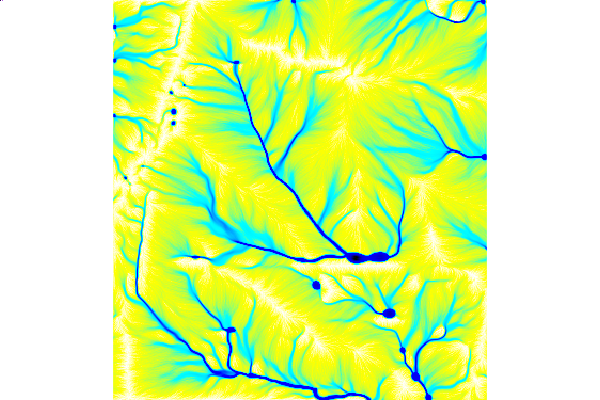

In [5]:
img = gj.GrassRenderer(use_region=True)
img.d_rast(map="wdp_2m.30")
img.d_rast(map="disch_2m.30")
# Display map
img.show()

Optionally, animate the time series:
_File > Animation tool_

#### *Question 1*
Comment on the resulting pattern - where is the water ponding and what is causing it at this location? Is this realistic?

In [6]:
#### Your Answer Here

### Peak runoff with preferential flow direction in the stream channel

To prevent ponding in a depression along the stream channel, we can add a preferential flow direction along the stream. This would, for example, correct for a stream flowing through a culvert under the road.

#### *Question 2*

Add preferential flow to the model above by giving cells along the stream a slope angle of 2 degrees and a downstream flow direction. The `v.to.rast` module may be helpful here - especially since it can return line direction. The formula for converting a direction angle to dx and dy is:

$ \delta x = \tan(\mu)*\cos(\alpha) $

$ \delta y = \tan(\mu)*\sin(\alpha) $

Where $\mu$ is the slope and $\alpha$ is the stream direction.

Finally, `r.mapcalc` or GRASS raster algebra has functions `if` and `isnull` which may be useful for combining the dx and dy rasters derived from the DEM and stream.

Data element 'vector/streams' was found in more mapsets (also found in
<PERMANENT>)
Using <streams@HW3_water_simulation>...
Reading features...
   3   6   9  12  16  19  22  25  29  32  35  38  41  45  48  51  54  58  61  64  67  70  74  77  80  83  87  90  93  96 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
v.to.rast complete.
Number of threads: 1

Min elevation = 103.89 m
Max elevation = 131.57 m
Mean Source Rate (rainf. excess or sediment) = 0.000014 m/s or kg/m2s
Mean flow velocity = 4.702121 m/s
Mean Mannings = 0.050000
Number of iterations = 4231 cells
Time step = 0.11 s
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100


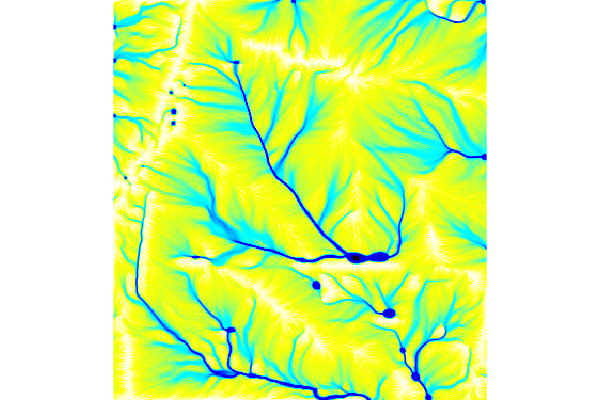

In [7]:
### Your Answer Here

# Answer:
!v.to.rast streams output=streams_dir_2m use=dir

#Compute stream dx and dy using the stream direction angle and a slope angle equal to 2 degrees:
!r.mapcalc "dxstr_2m = tan(2.)*cos(streams_dir_2m)"
!r.mapcalc "dystr_2m = tan(2.)*sin(streams_dir_2m)"

#Compute flow gradient vector by combining dx and dy derived from the DEM and stream:
!r.mapcalc "dxdemstr_2m = if(isnull(dxstr_2m), dx_2m, dxstr_2m)"
!r.mapcalc "dydemstr_2m = if(isnull(dystr_2m), dy_2m, dystr_2m)"

#Run the overland flow model:
!r.sim.water -t elevation=elev_lid792_2m dx=dxdemstr_2m dy=dydemstr_2m rain_value=50 infil_value=0 man_value=0.05 depth=wdpstr_2m discharge=dischstr_2m nwalkers=100000 niterations=30 output_step=2

#Display Map
img = gj.GrassRenderer(use_region=True)
img.d_rast(map="dischstr_2m.30")
img.show()

#### Runoff for spatially variable landcover and rainfall excess

We can continue to improve the model above by accounting for spatially varying landcover and rainfall. In this section, we compute runoff for spatially variable landcover (represented by spatially variable Mannings coefficient) and rainfall excess (rainfall intensity - infiltration rate).


We will use variable Mannings coefficient defined by reclassifying land cover class. Find out the land use categories in the map landcover_1m:

In [8]:
print(gs.read_command("r.category", map="landcover_1m"))

1	pond
2	forest
3	developed
4	bare
5	paved road
6	dirt road
7	vineyard
8	agriculture
9	wetland
10	bare ground path
11	grass



Let's also render a map of landcover:

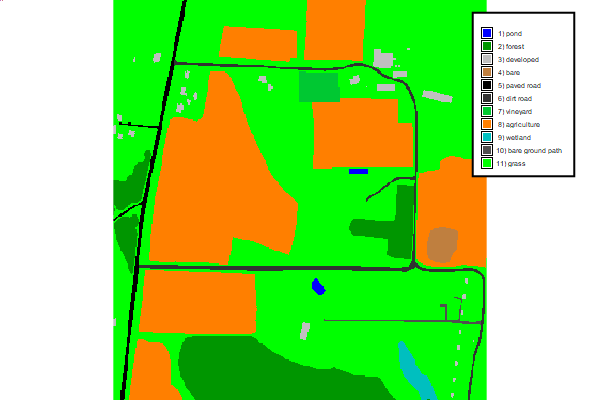

In [10]:
# Create GrassRenderer instance
img = gj.GrassRenderer(use_region=True)
img.d_rast(map="landcover_1m")
img.d_legend(raster="landcover_1m", at=(55, 95, 80, 84), flags="b")
# Display map
img.show()   

Next, we assign each category a Mannings roughness coefficient (published in literature) by recoding the landcover map using the _[r.recode](https://grass.osgeo.org/grass74/manuals/r.recode.html)_ module and reclassification rules stored in 
[`land_to_mannings.txt`](./land_to_mannings.txt):

In [11]:
gs.run_command("r.recode", input="landcover_1m", output="mancover_2m", rules="land_to_mannings.txt")

Similarly, we will create raster with spatially variable rainfall excess rates based on the land cover classes. We use [`land_to_rain.txt`](./land_to_rain.txt) to specify the rates for individual classes. Again, we use the file as rules for the _[r.recode](https://grass.osgeo.org/grass74/manuals/r.recode.html)_ module.

In [12]:
gs.run_command("r.recode", input="landcover_1m", output="raincover_2m", rules="land_to_rain.txt")

#### *Question 3*

Modify the following code so that it uses the dx and dy rasters from Question 2 with preferential stream flow:

In [13]:
gs.run_command("r.sim.water",
               elevation="elev_lid792_2m",
               dx="dx_2m",
               dy="dy_2m",
               rain="raincover_2m",
               infil_value=0,
               man="mancover_2m",
               depth="wdpstrcov_2m",
               discharge="distrcov_2m",
               nwalkers=100000,
               niterations=30,
               output_step=2,
               flags="t")

Display the static results.

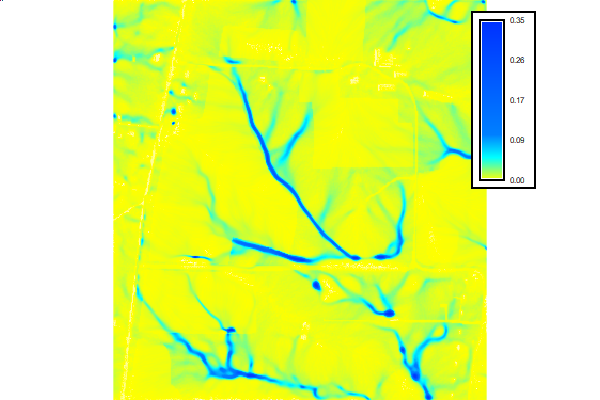

In [14]:
# Depth
img = gj.GrassRenderer(use_region=True)
img.d_rast(map="wdpstrcov_2m.30")
img.d_legend(raster="wdpstrcov_2m.30", at=(55, 95, 80, 84), flags="b")
img.show() 

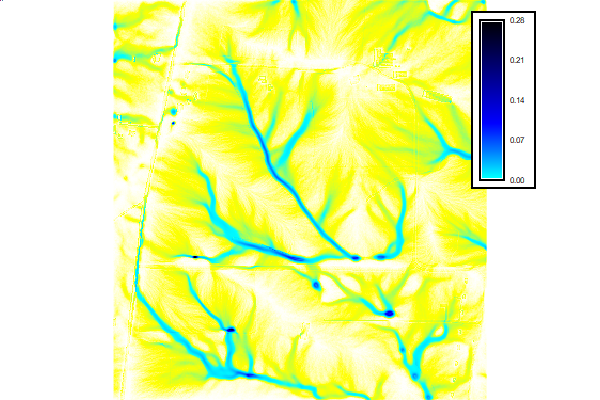

In [15]:
# Discharge
img = gj.GrassRenderer(use_region=True)
img.d_rast(map="distrcov_2m.30")
img.d_legend(raster="distrcov_2m.30", at=(55, 95, 80, 84), flags="b")
img.show() 

Optionaly animate the time series using the Animation tool.

#### *Question 4*
Comment on the resulting pattern - how is the flow depth related to the landcover?
Which landcover holds most water?

In [16]:
#### Your Answer Here

### Sediment flow rate, erosion and deposition

Compute sediment flow rate and net erosion/deposition using sediment
transport part of the SIMWE model implemented in the
the _[r.sim.sediment](https://grass.osgeo.org/grass74/manuals/r.sim.sediment.html)_ module.
To make the computations faster, set region just to the upper part of
the watershed:

In [17]:
gs.run_command("g.region", s="s+290")

Compute input transport capacity and detachment coefficient maps:

In [18]:
gs.mapcalc("tranin = 0.001")
gs.mapcalc("detin = 0.001")

Compute input critical shear stress:

In [19]:
gs.mapcalc("tauin = 0.01")

Run the model using the last depth from previous run:

In [20]:
gs.run_command("g.copy", rast="wdp_2m.30,wdp_2m")
gs.run_command("r.sim.sediment",
               elevation="elev_lid792_2m",
               dx="dx_2m",
               dy="dy_2m",
               water_depth="wdp_2m",
               detachment_coeff="detin",
               transport_coeff="tranin",
               shear_stress="tauin",
               man_value=0.05,
               nwalkers=1000000,
               niterations=30,
               transport_capacity="tcapacity",
               tlimit_erosion_deposition="erdepmax",
               sediment_flux="sedflow",
               erosion_deposition="erdepsimwe")

Display the results:

In [21]:
# Create Interactive Map
fig = gj.InteractiveMap(use_region=True)
# Add raster, vector and layer control to map
fig.add_raster("tcapacity", opacity=1.0)
fig.add_raster("erdepmax", opacity=1.0)
fig.add_raster("sedflow", opacity=1.0)
fig.add_raster("erdepsimwe", opacity=1.0)
fig.add_layer_control(position = "bottomright")
# Display map
fig.show()

#### *Question 5*

Describe the results shown on the map. What is shown in each of the layers?

In [22]:
#### Your Answer Here.

### Additional Information
* [Website](https://github.com/ncsu-geoforall-lab/geospatial-simulations-course)
    
* [Computing Help](https://help.ncsu.edu/)
    
* [GIST Home](https://geospatial.ncsu.edu/)
    
* [Disclaimer](https://www.ncsu.edu/policies/prr-disclaimer.php)
    
* [Accessibility](https://oit.ncsu.edu/itaccess)

* License: 2018 [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/)
  
* [NCSU GeoForAll Lab](https://geospatial.ncsu.edu/geoforall/)